In [3]:
import numpy as np
import pandas as pd
# import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

In [4]:
classes = {'1NonCOVID': 0, '2COVID': 1, '3CAP': 2}
declasses = {0: '1NonCOVID', 1: '2COVID', 2: '3CAP'}

In [5]:
class GetDataset(Dataset):
    def __init__(self, path, folder, channel, transform=None):
        self.path = path
        self.folder = folder
        self.channel = channel
        self.transform = transform

    def __len__(self):
        return len(os.listdir(os.path.join(self.path, self.folder)))

    def __getitem__(self, index):
        img_name = sorted(os.listdir(os.path.join(self.path, self.folder)))[index]
        
        if self.channel == 3:
            ch = 'RGB'
        else:
            ch = 'L'
            
        image = Image.open(os.path.join(self.path, self.folder, img_name)).convert(ch)
        label = classes[self.folder]
        
        if self.transform:
            image = self.transform(image)
            

        return image, label

In [6]:
PATH = '../input/large-covid19-ct-slice-dataset/curated_data/curated_data/'
Folders = ['1NonCOVID', '2COVID', '3CAP']
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=32
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [7]:
noncovid = GetDataset(PATH, Folders[0], channels, transformer)
covid = GetDataset(PATH, Folders[1], channels, transformer)
cap = GetDataset(PATH, Folders[2], channels, transformer)

In [8]:
print(len(noncovid), noncovid[0][0].size())
print(len(covid), covid[0][0].size())
print(len(cap), cap[0][0].size())

6893 torch.Size([3, 224, 224])
7593 torch.Size([3, 224, 224])
2618 torch.Size([3, 224, 224])


In [9]:
def denorm(image, stats=stats):
    return image * stats[1][0] + stats[0][0]

In [10]:
from torch.utils.data import random_split, ConcatDataset
import torch

torch.manual_seed(42)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    test_len = total_len - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

noncovid_train, noncovid_val, noncovid_test = split_dataset(noncovid, train_ratio, val_ratio, test_ratio)
covid_train, covid_val, covid_test = split_dataset(covid, train_ratio, val_ratio, test_ratio)
cap_train, cap_val, cap_test = split_dataset(cap, train_ratio, val_ratio, test_ratio)

train_dataset = ConcatDataset([noncovid_train, covid_train, cap_train])
val_dataset = ConcatDataset([noncovid_val, covid_val, cap_val])
test_dataset = ConcatDataset([noncovid_test, covid_test, cap_test])

print(len(train_dataset), len(val_dataset), len(test_dataset)) 


11972 3419 1713


In [11]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# pip install --upgrade torchvision==0.13

In [14]:
import torch
import torch.nn as nn
from torchvision import models

import torch
import torch.nn as nn
from torchvision.models import vit_b_16

class ViTClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.model = vit_b_16(pretrained=True)
        in_features = self.model.heads.head.in_features
        self.model.heads.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化 ViT 模型
model = ViTClassifier(num_classes=3).to(device)
model 



/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ViTClassifier(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate=none)
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

In [15]:
# 定义损失函数和优化器
learning_rate = 1e-6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
train_dataset = torch.utils.data.Subset(train_dataset, range(0, len(train_dataset), 10))
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)


In [17]:
def train_model(model, train_dl, val_dl, optimizer, loss_fn, device, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_auc': [], 'val_auc': []}
    
    model.to(device)

    for epoch in range(num_epochs):
        model.train()


        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()


        train_loss, train_acc, train_auc = evaluate_model(model, train_dl, loss_fn, device)
        val_loss, val_acc, val_auc = evaluate_model(model, val_dl, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    return history


In [18]:
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    val_losses, preds, targets = [], [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)

            val_losses.append(loss.item())
            preds.append(out.cpu())
            targets.append(yb.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    
    probs = torch.softmax(preds, dim=1) 
    val_acc = accuracy_score(targets, probs.argmax(dim=1))
    val_auc = roc_auc_score(targets.numpy(), probs.numpy(), multi_class='ovr')

    return np.mean(val_losses), val_acc, val_auc


In [19]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_auc'], label='Train AUC')
    plt.plot(epochs, history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC Curve')

    plt.tight_layout()
    plt.show()


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_and_plot(model, dataloader, device, class_names):
    model.eval()
    y_true = []
    y_prob = []
    
    # 预测结果
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            
            # 获取预测的概率值
            probs = torch.softmax(outputs, dim=1)
            y_true.append(yb.cpu().numpy())
            y_prob.append(probs.cpu().numpy())
    
    y_true = np.concatenate(y_true, axis=0)
    y_prob = np.concatenate(y_prob, axis=0)
    
    # 1. 绘制混淆矩阵
    cm = confusion_matrix(y_true, y_prob.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    # 2. 计算和绘制每个类别的 ROC 曲线
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # 3. 计算并返回 AUC
    auc_value = roc_auc_score(y_true, y_prob, multi_class='ovr')
    print(f"Overall AUC: {auc_value:.2f}")

    # 4. 输出分类报告
    report = classification_report(y_true, y_prob.argmax(axis=1), target_names=class_names)
    print("Classification Report:\n", report)


Epoch 1/20: Train Loss=0.8411, Val Loss=0.8519, Train Acc=0.6594, Val Acc=0.6598
Epoch 2/20: Train Loss=0.7337, Val Loss=0.7506, Train Acc=0.6886, Val Acc=0.6873
Epoch 3/20: Train Loss=0.6568, Val Loss=0.6861, Train Acc=0.7053, Val Acc=0.6952
Epoch 4/20: Train Loss=0.5876, Val Loss=0.6346, Train Acc=0.7746, Val Acc=0.7444
Epoch 5/20: Train Loss=0.5329, Val Loss=0.5948, Train Acc=0.8189, Val Acc=0.7724
Epoch 6/20: Train Loss=0.4798, Val Loss=0.5557, Train Acc=0.8556, Val Acc=0.7920
Epoch 7/20: Train Loss=0.4359, Val Loss=0.5237, Train Acc=0.8781, Val Acc=0.8134
Epoch 8/20: Train Loss=0.3946, Val Loss=0.4944, Train Acc=0.8881, Val Acc=0.8187
Epoch 9/20: Train Loss=0.3545, Val Loss=0.4682, Train Acc=0.8990, Val Acc=0.8333
Epoch 10/20: Train Loss=0.3257, Val Loss=0.4488, Train Acc=0.9048, Val Acc=0.8309
Epoch 11/20: Train Loss=0.2885, Val Loss=0.4234, Train Acc=0.9182, Val Acc=0.8479
Epoch 12/20: Train Loss=0.2589, Val Loss=0.4091, Train Acc=0.9391, Val Acc=0.8596
Epoch 13/20: Train Loss=0

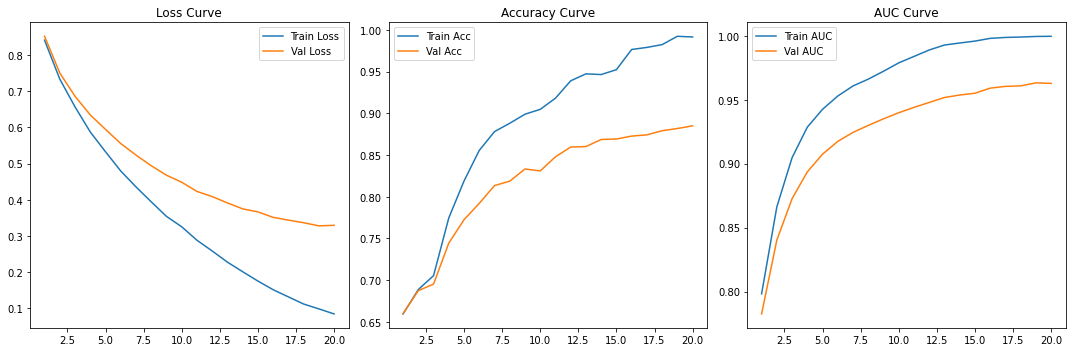

== 验证集评估 ==


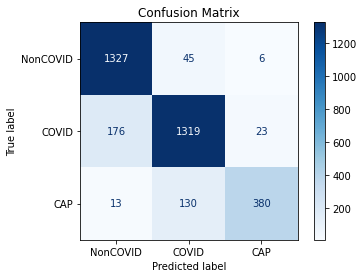

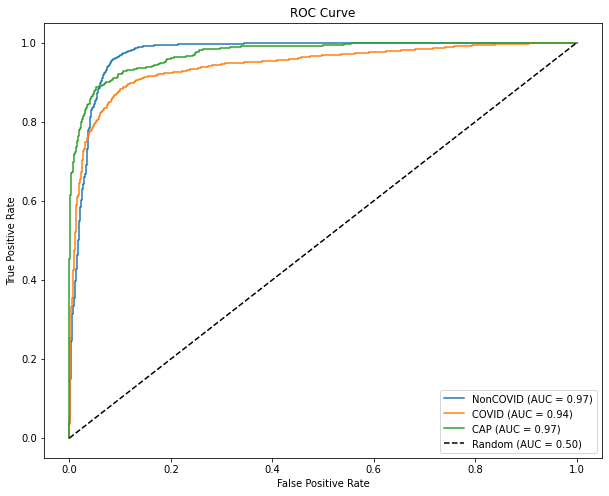

Overall AUC: 0.96
Classification Report:
               precision    recall  f1-score   support

    NonCOVID       0.88      0.96      0.92      1378
       COVID       0.88      0.87      0.88      1518
         CAP       0.93      0.73      0.82       523

    accuracy                           0.89      3419
   macro avg       0.90      0.85      0.87      3419
weighted avg       0.89      0.89      0.88      3419

== 测试集评估 ==


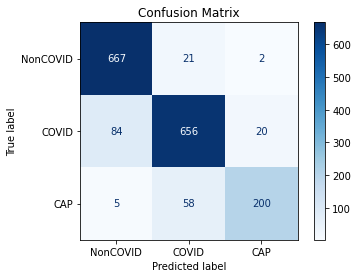

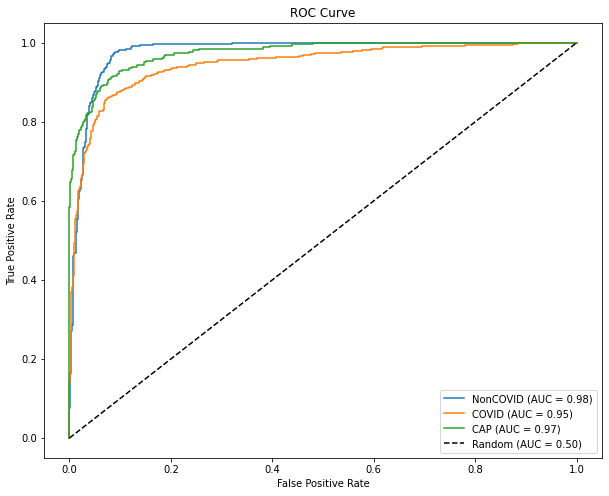

Overall AUC: 0.97
Classification Report:
               precision    recall  f1-score   support

    NonCOVID       0.88      0.97      0.92       690
       COVID       0.89      0.86      0.88       760
         CAP       0.90      0.76      0.82       263

    accuracy                           0.89      1713
   macro avg       0.89      0.86      0.87      1713
weighted avg       0.89      0.89      0.89      1713



In [21]:
class_names = ['NonCOVID', 'COVID', 'CAP']

history = train_model(model, train_dl, val_dl, optimizer, criterion, device, num_epochs=20)
plot_training_curves(history)

print("== 验证集评估 ==")
evaluate_and_plot(model, val_dl, device, class_names)

print("== 测试集评估 ==")
evaluate_and_plot(model, test_dl, device, class_names)
